In [1]:
## Setting up options to be used during the process
base_country = "Brazil"
compared_country = "United States"
#compared_country = "India"
#metric = "confirmed"
#metric = "cases_per_million"
metric = "fatalities_per_million"
countries = [base_country, compared_country]

In [2]:
import urllib.request 
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import datetime
import shutil
import imageio

In [3]:
## Download and unzip COVID cases
temporary_folder = os.path.join(os.getcwd(), 'tmp')
if os.path.exists(temporary_folder):
    shutil.rmtree(temporary_folder)  
    
if not os.path.exists(temporary_folder):
    os.makedirs(temporary_folder)
    
remote_file_name = "https://github.com/CSSEGISandData/COVID-19/archive/master.zip"
base_name = os.path.basename(remote_file_name)
local_file_name = os.path.join(temporary_folder, base_name)

urllib.request.urlretrieve(remote_file_name, local_file_name)

data_folder = os.path.join(os.getcwd(), 'world_data') 
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)  
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    
with zipfile.ZipFile(local_file_name, 'r') as zip_ref:
    zip_ref.extractall(data_folder)
    
#!unzip master.zip

In [4]:
## Download world population
remote_file_name = "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=excel"
world_population_file = os.path.join(temporary_folder, "world_population.xls")

# The following statement is throwing an alert but the download is being performed anyway
try:
    urllib.request.urlretrieve(remote_file_name, world_population_file) 
except:
    print("Some error happened when downloading")
finally:
    if os.path.exists(world_population_file):
        print("Despite the warning message, file was downloaded anyway!")

Despite the warning message, file was downloaded anyway!


In [5]:
## Load world population DataFrame
world_population = pd.read_excel(world_population_file, sheet_name="Data", dtype=object, skiprows=3)
world_population = world_population[["Country Name", "Country Code", "2018"]]
world_population = world_population.rename(
    {"Country Name":"country","Country Code":"country_code", "2018":"population"}, 
    axis='columns') 

world_population['population'] = world_population['population'].fillna(0)
world_population['population'] = world_population['population'].astype('int')

In [6]:
## Load COVID cases and standardizing the datasets
covid_folder = os.path.join(data_folder, 'COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/')

li = []
file_list = os.listdir(covid_folder)
file_list.sort()

df = pd.read_csv(os.path.join(covid_folder, '05-25-2020.csv'), index_col=None, header=0)

if "Admin2" in df:
    df = df.rename({"Admin2":"county"}, axis="columns")

if "Province/State" in df:
    df = df.rename({"Province/State":"province_state"}, axis="columns")
elif "Province_State" in df:
    df = df.rename({"Province_State":"province_state"}, axis="columns")

if "Country/Region" in df:
    df = df.rename({"Country/Region":"country"}, axis="columns")
elif "Country_Region" in df:
    df = df.rename({"Country_Region":"country"}, axis="columns")

if "Last Update" in df:
    df = df.rename({"Last Update":"last_update"}, axis="columns")
elif "Last_Update" in df:
    df = df.rename({"Last_Update":"last_update"}, axis="columns")

if "Confirmed" in df:
    df = df.rename({"Confirmed":"confirmed"}, axis="columns")

if "Deaths" in df:
    df = df.rename({"Deaths":"deaths"}, axis="columns")
    
if "Recovered" in df:
    df = df.rename({"Recovered":"recovered"}, axis="columns")
    
if "Active" in df:
    df = df.rename({"Active":"active"}, axis="columns")

if "Lat" in df:
    df = df.rename({"Lat":"latitude"}, axis="columns")

if "Long_" in df:
    df = df.rename({"Long_":"longitude"}, axis="columns")

if "Combined_Key" in df:
    df = df.rename({"Combined_Key":"full_location"}, axis="columns")    


In [7]:
## Load COVID cases and standardizing the datasets
covid_folder = os.path.join(data_folder, 'COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/')

li = []
file_list = os.listdir(covid_folder)
file_list.sort()

for covid_file in file_list:
    if covid_file.find(".csv") > -1:
        df = pd.read_csv(os.path.join(covid_folder, covid_file), index_col=None, header=0)
        if "Admin2" in df:
            df = df.rename({"Admin2":"county"}, axis="columns")

        if "Province/State" in df:
            df = df.rename({"Province/State":"province_state"}, axis="columns")
        elif "Province_State" in df:
            df = df.rename({"Province_State":"province_state"}, axis="columns")

        if "Country/Region" in df:
            df = df.rename({"Country/Region":"country"}, axis="columns")
        elif "Country_Region" in df:
            df = df.rename({"Country_Region":"country"}, axis="columns")

        if "Last Update" in df:
            df = df.rename({"Last Update":"last_update"}, axis="columns")
        elif "Last_Update" in df:
            df = df.rename({"Last_Update":"last_update"}, axis="columns")

        if "Confirmed" in df:
            df = df.rename({"Confirmed":"confirmed"}, axis="columns")

        if "Deaths" in df:
            df = df.rename({"Deaths":"deaths"}, axis="columns")

        if "Recovered" in df:
            df = df.rename({"Recovered":"recovered"}, axis="columns")

        if "Active" in df:
            df = df.rename({"Active":"active"}, axis="columns")

        if "Lat" in df:
            df = df.rename({"Lat":"latitude"}, axis="columns")
        elif "Latitude" in df:
            df = df.rename({"Latitude":"latitude"}, axis="columns")

        if "Long_" in df:
            df = df.rename({"Long_":"longitude"}, axis="columns")
        elif "Longitude" in df:
            df = df.rename({"Longitude":"longitude"}, axis="columns")
            
        if "Combined_Key" in df:
            df = df.rename({"Combined_Key":"full_location"}, axis="columns")    
            
        #df = df[["county", "province_state", "country", "last_update", "confirmed", "deaths", "recovered", "active", "latitude", "longitude", "full_location"]]
        li.append(df)

covid_cases = pd.concat(li, axis=0, ignore_index=True)
covid_cases = covid_cases[["full_location", "county", "province_state", "country", "last_update", "confirmed", "deaths", "recovered", "active", "latitude", "longitude"]]

covid_cases = covid_cases.replace("Mainland China", "China")
covid_cases = covid_cases.replace("US", "United States")
covid_cases = covid_cases.replace("UK", "United Kingdom")
covid_cases = covid_cases.replace("Iran (Islamic Republic of)", "Iran")
covid_cases = covid_cases.replace("Russian Federation", "Russia")
covid_cases = covid_cases.replace("Republic of Korea", "South Korea")
covid_cases = covid_cases.replace("Hong Kong SAR", "Hong Kong")
covid_cases = covid_cases.replace("Viet Nam", "Vietnam")
covid_cases = covid_cases.replace("Macao SAR", "Macau")
covid_cases = covid_cases.replace("Korea, South", "South Korea")
covid_cases = covid_cases.replace("North Ireland", "United Kingdom")
covid_cases = covid_cases.replace("Republic of Ireland", "Ireland")

covid_cases["last_update"] = pd.to_datetime(covid_cases["last_update"])
covid_cases["last_update"] = covid_cases["last_update"].dt.date


In [8]:
## Creating folder to hold extractions and generating the dataset dump
ext_folder = os.path.join(os.getcwd(), 'extractions') 
if os.path.exists(ext_folder):
    shutil.rmtree(ext_folder)  
if not os.path.exists(ext_folder):
    os.makedirs(ext_folder)
file_name = os.path.join(ext_folder, "merged_data.csv")
covid_cases.to_csv(file_name, index=False)

In [9]:
## Adjust country names and merging dataframes
world_population = world_population.replace("Korea, Rep.", "South Korea")
world_population = world_population.replace("Hong Kong SAR, China", "Hong Kong")
world_population = world_population.replace("Iran, Islamic Rep.", "Iran")
world_population = world_population.replace("Russian Federation", "Russia")
world_population = world_population.replace("Macao SAR, China", "Macau")
world_population = world_population.replace("Venezuela, RB", "Venezuela")
world_population = world_population.replace("Bahamas, The", "The Bahamas")
world_population = world_population.replace("Egypt, Arab Rep.", "Egypt")
world_population = world_population.replace("Slovak Republic", "Slovakia")

covid_cases_pop = pd.merge(covid_cases, world_population, how='left', on='country')

# The following line was used to check countries on population dataset and not on cases dataset and vice-versa
# print(((covid_cases_pop[covid_cases_pop['population'].isnull()])["country"]).drop_duplicates())

In [10]:
## Remove countries with no population 
covid_cases_pop['population'] = covid_cases_pop['population'].fillna(0)
covid_cases_pop = covid_cases_pop.loc[covid_cases_pop['population'] != 0]
covid_cases_pop['population'] = covid_cases_pop['population'].astype('int')


covid_cases_aggr = covid_cases_pop[["country", "last_update", "population", "confirmed", "deaths"]]
#covid_cases_aggr = covid_cases_aggr.loc[covid_cases_aggr["confirmed"] >= 100]

In [11]:
## Aggregate by country, date and population
covid_cases_aggr = covid_cases_aggr.groupby(["country", "last_update", "population"]).sum()
covid_cases_aggr = covid_cases_aggr.reset_index()

In [12]:
## TO DO: adjust deviations caused by data issues and data reporting methodology changes by removing
##        any day that has less cases than the day before

# covid_cases_aggr = covid_cases_aggr[covid_cases_aggr["confirmed"] > 0]
# #country_dates = pd.date_range(start=covid_cases_aggr.last_update.min(), end=covid_cases_aggr.last_update.max())
# #covid_cases_aggr = covid_cases_aggr.set_index('last_update').reindex(country_dates).fillna(method='pad').rename_axis('last_update').reset_index()
# #country_cases = country_cases.reset_index()
# #country_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
# #country_cases_before = country_cases[["days_since_first_case", "confirmed", "deaths"]]
# #country_cases_before = country_cases_before.rename({"confirmed":"confirmed_previous", "deaths":"deaths_previous"}, axis="columns")
# #country_cases_before["days_since_first_case"] = (country_cases_before["days_since_first_case"] + 1)

# #country_cases = pd.merge(country_cases, country_cases_before, how='left', on='days_since_first_case')

# covid_cases_aggr.groupby('country')['last_update'].rank()
# #covid_cases_aggr



In [13]:
## Function to generate forecast for N days (set on days_to_forecast variable) beyond the last data point
## It uses an exponential regresion as a model to forecast
def generate_forecast(countries, days_to_forecast, ending_day):
    li = []

    for country in countries:
        country_cases = covid_cases_aggr[covid_cases_aggr["country"] == country]
        country_cases = country_cases[country_cases["confirmed"] > 0]
        country_dates = pd.date_range(start=country_cases.last_update.min(), end=covid_cases_aggr.last_update.max())
        country_cases = country_cases.set_index('last_update').reindex(country_dates).fillna(method='pad').rename_axis('last_update').reset_index()
        country_cases = country_cases.reset_index()
        country_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
        if countries[0] == country:
            country_cases = country_cases[country_cases["days_since_first_case"] <= ending_day]
        country_cases["type"] = "actuals"
        x = np.array((country_cases["days_since_first_case"]))
        y = np.array((country_cases["confirmed"]))
        confirmed_cases_pred = np.polyfit(x, np.log(y), 1)

        population = int((country_cases["population"]).tail(1))                       
        death_rate = float((country_cases["deaths"].tail(1) * 1.0000) / (country_cases["confirmed"].tail(1) * 1.0000))
        for i in range(1 , country_cases["days_since_first_case"].max() + days_to_forecast - 1):
            confirmed = np.exp(confirmed_cases_pred[1]) * np.exp(confirmed_cases_pred[0] * i) 
            deaths = confirmed * death_rate
            row = {
                "days_since_first_case": i,
                "last_update": (country_cases["last_update"].min() + datetime.timedelta(days=i)),
                "country": country,
                "population": population,
                "confirmed": round(confirmed),
                "deaths": round(deaths),
                "type": "forecast"
            }
            country_cases = country_cases.append(row, ignore_index=True)
        li.append(country_cases)

    covid_cases_final = pd.concat(li, axis=0, ignore_index=True)
    ## Add rate columns
    covid_cases_final["cases_per_million"] = covid_cases_final["confirmed"] / (covid_cases_final["population"] / 1000000)
    covid_cases_final["fatalities_per_million"] = covid_cases_final["deaths"] / (covid_cases_final["population"] / 1000000)
    covid_cases_final["fatalities_per_cases"] = covid_cases_final["deaths"] / covid_cases_final["confirmed"]
    
    return covid_cases_final 

In [14]:
## Function to generate chart comparing a country, its forecasted data to other countries (up to 3)
def generate_chart(countries, metric, days_to_forecast, ending_day, **kwargs):
    covid_cases_final = generate_forecast(countries, days_to_forecast, ending_day)
    
    plt.figure(num=None, figsize=(12, 6), dpi=300, facecolor='w', edgecolor='k')
    plt.xlabel('Days Since First Confirmed Case')
    if metric == 'cases_per_million':
        plt.ylabel('Cases Per Million')
    elif metric == "confirmed":
        plt.ylabel('Confirmed Cases')
    elif metric == "fatalities_per_million":
        plt.ylabel('Fatalities Per Million')
        
    if "add_to_title" in kwargs:
        plt.title('COVID-19 Country Curves Comparison' + kwargs["add_to_title"])        
    else:
        covid_cases_country = covid_cases_final[covid_cases_final["country"] == countries[0]]
        covid_cases_country = covid_cases_country[covid_cases_country["confirmed"] > 0]
        covid_cases_country = covid_cases_country[covid_cases_country["type"] == "actuals"]
        last_update = (covid_cases_country["last_update"]).max()
        max_days = (covid_cases_country["days_since_first_case"]).max()
        add_to_title = ": " + countries[0] + " - Day #" + str(max_days) + " (" + str(last_update)[:10] + ")"
        plt.title('COVID-19 Country Curves Comparison - Base Country' + add_to_title)

    comparing_country_legend = countries[0]
    comparing_country = covid_cases_final[covid_cases_final["country"] == comparing_country_legend]
    point_in_time = comparing_country["days_since_first_case"].max()
    green_legend = mpatches.Patch(color='green', label=comparing_country_legend)
    green_legend_forecast = mpatches.Patch(color='cyan', label=comparing_country_legend + " (forecast)", linestyle = ':')
    plt.plot('days_since_first_case', metric, data=comparing_country[comparing_country["type"] == "actuals"], linewidth=3, color="green")
    plt.plot('days_since_first_case', metric, data=comparing_country[comparing_country["type"] == "forecast"], linewidth=3, color="cyan", linestyle = ':')
    x_pos = (comparing_country[comparing_country["type"] == "actuals"])["days_since_first_case"].max()
    y_pos = (comparing_country[(comparing_country["type"] == "actuals")])
    y_pos = (y_pos[y_pos["days_since_first_case"] == x_pos])[metric]
    line_label = (
        "day #" + str(x_pos) + 
        " (" + str((comparing_country[comparing_country["type"] == "actuals"])["last_update"].max())[:10] + ")"
    )
    #plt.text(x_pos, y_pos * 1.1, line_label, ha='right', color="green")
    handles=[green_legend, green_legend_forecast]
    
    if len(countries) > 1:
        comparing_country = countries[1]
        red_legend = mpatches.Patch(color='red', label=comparing_country)
        comparing_country = covid_cases_final[covid_cases_final["country"] == comparing_country]
        comparing_country = comparing_country[comparing_country["days_since_first_case"] <= point_in_time]
        plt.plot('days_since_first_case', metric, data=comparing_country[comparing_country["type"] == "actuals"], linewidth=3, color="red")
        handles.append(red_legend)
        
    if len(countries) > 2:
        comparing_country = countries[2]
        blue_legend = mpatches.Patch(color='blue', label=comparing_country)
        comparing_country = covid_cases_final[covid_cases_final["country"] == comparing_country]
        comparing_country = comparing_country[comparing_country["days_since_first_case"] <= point_in_time]
        plt.plot('days_since_first_case', metric, data=comparing_country[comparing_country["type"] == "actuals"], linewidth=3, color="blue")
        handles.append(blue_legend)
        
    if len(countries) > 3:
        comparing_country = countries[3]
        black_legend = mpatches.Patch(color='black', label=comparing_country)
        comparing_country = covid_cases_final[covid_cases_final["country"] == comparing_country]
        comparing_country = comparing_country[comparing_country["days_since_first_case"] <= point_in_time]
        plt.plot('days_since_first_case', metric, data=comparing_country[comparing_country["type"] == "actuals"], linewidth=3, color="black")
        handles.append(black_legend)

    if "y_max" in kwargs:
        #print(kwargs["y_max"])
        plt.ylim(top=kwargs["y_max"])
    plt.ylim(bottom=0)
    max_x_axis, max_y_axis = plt.ylim()
    plt.legend(handles=handles)
    plt.text(0, (max_y_axis / 7 * -1), "Source: 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE (https://github.com/CSSEGISandData/COVID-19)", ha='left')
    if "save_chart" in kwargs:
        if kwargs["save_chart"] == True:
            plt.savefig(kwargs["file_name"], dpi=100, format='png', bbox_inches='tight')
            plt.close()
            #print(kwargs["file_name"])
        
    #plt.show()

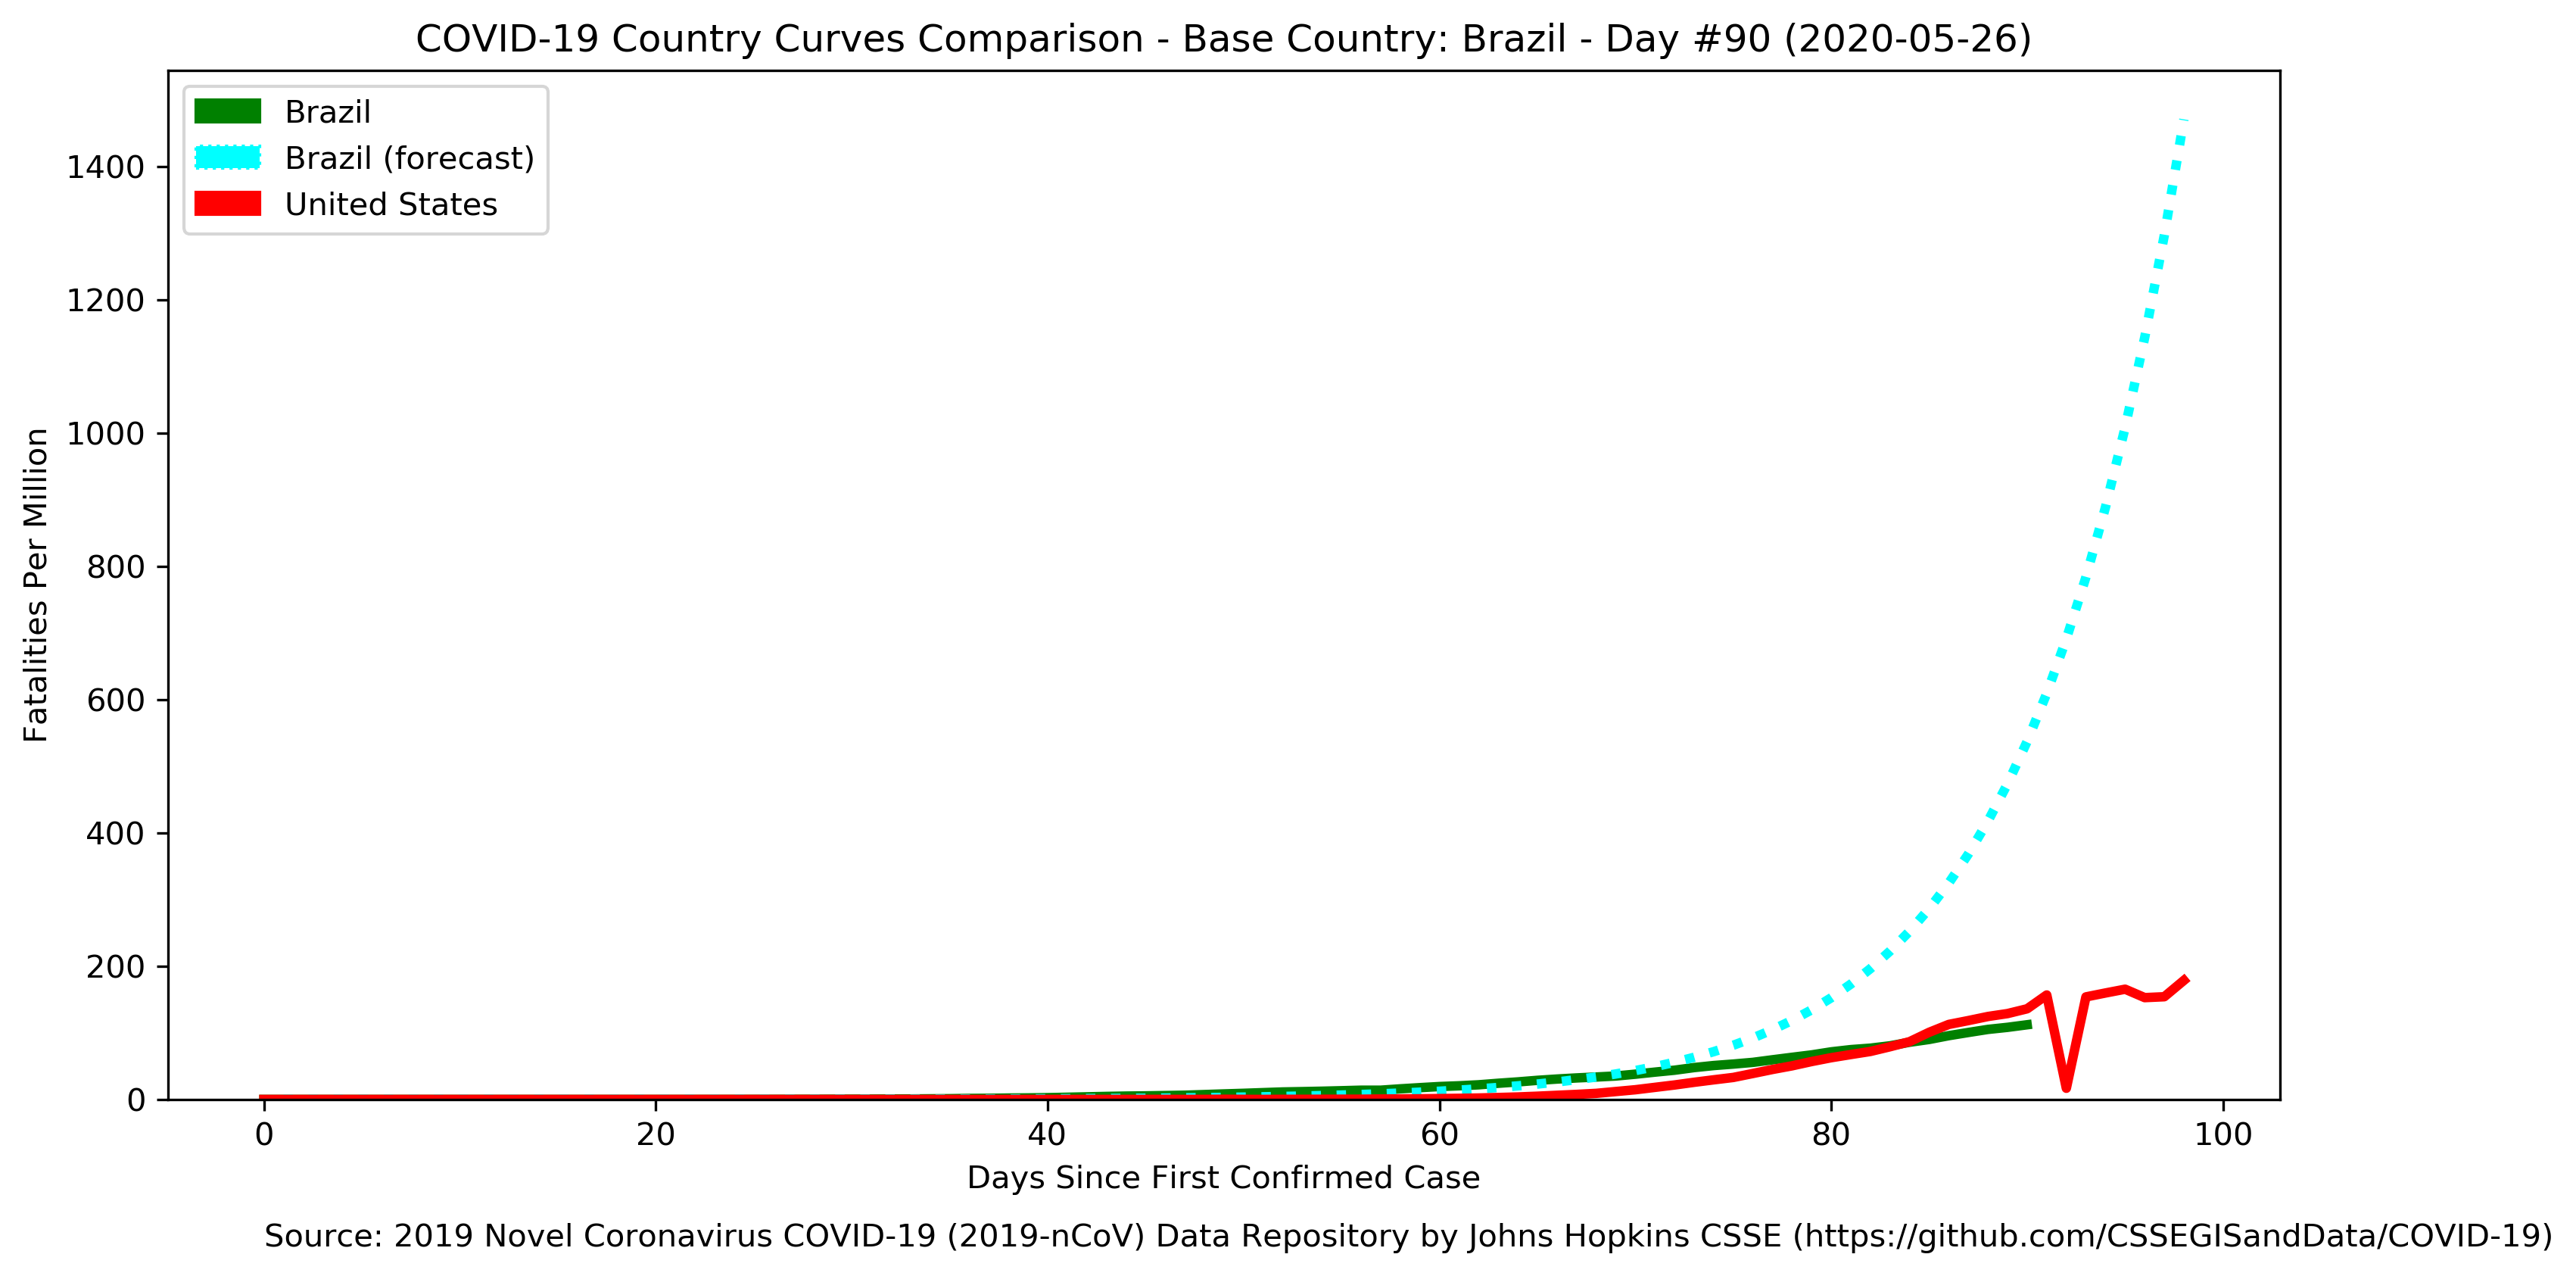

In [15]:
## Generates chart based on the two functions above
generate_chart(countries=countries, metric=metric, days_to_forecast=10, ending_day=1000)

In [16]:
## Function to generate an animation with the behavior of forecast along the timeline
def generate_animation(country_base, country_compared, metric):

    img_folder = os.path.join(os.getcwd(), 'img') 
    if os.path.exists(img_folder):
        shutil.rmtree(img_folder)  
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)

    covid_cases_country = covid_cases_aggr[covid_cases_aggr["country"] == country_base]
    covid_cases_country = covid_cases_country[covid_cases_country["confirmed"] > 0]
    first_case = (covid_cases_country["last_update"]).min()
    last_update = (covid_cases_country["last_update"]).max()
    max_days = (last_update - first_case).days

    covid_cases_country = covid_cases_aggr[covid_cases_aggr["country"] == country_compared]
    covid_cases_country = covid_cases_country[covid_cases_country["last_update"] == (covid_cases_country["last_update"]).max()]
    covid_cases_country["cases_per_million"] = covid_cases_country["confirmed"] / (covid_cases_country["population"] / 1000000)
    covid_cases_country["fatalities_per_million"] = covid_cases_country["deaths"] / (covid_cases_country["population"] / 1000000)
    covid_cases_country["fatalities_per_cases"] = covid_cases_country["deaths"] / covid_cases_country["confirmed"]

    y_max = int(covid_cases_country[metric] * 1.05)

    for i in range(10 , max_days + 1):
        processing_date = first_case + datetime.timedelta(days=i) 
        add_to_title = ": " + country_base + " - Day #" + str(i) + " (" + str(processing_date) + ")"
        file_name = os.path.join(img_folder, (str(i) + ".png"))
        generate_chart(
            countries=[country_base, country_compared], 
            metric=metric, 
            days_to_forecast=10, 
            ending_day=i, 
            save_chart = True, 
            file_name=file_name, 
            add_to_title=add_to_title
        )



    animation_folder = os.path.join(os.getcwd(), 'animation') 
    if not os.path.exists(animation_folder):
        os.makedirs(animation_folder)

    images = []
    for filename in sorted(os.listdir(img_folder)):
        file_path = os.path.join(img_folder, filename)
        images.append(imageio.imread(file_path))
    output_file = country_base + "_vs_" + country_compared + "_" + metric + ".gif"
    output_file = os.path.join(animation_folder, output_file)
    print(output_file)
    imageio.mimsave(output_file, images, duration=1)

In [17]:
## Generate animation with the change in forecast along the epidemic timeline
generate_animation(country_base = base_country, country_compared = compared_country, metric = metric)

/Users/wcunha69/Documents/projects/COVID-19/animation/Brazil_vs_United States_fatalities_per_million.gif


In [18]:
## Function to generata a chart comparing how long (in days) is taking to double that metric
def generate_chart_days_to_double(countries, metric):
    #countries = ["Brazil", "United States"]
    #covid_cases_aggr
    metric_previous = metric + "_previous"
    metric_to_double = metric + "_days_to_double"
    li = []

    start_day = None
    end_day = None 

    for country in countries:
        country_cases = covid_cases_aggr[covid_cases_aggr["country"] == country]
        country_cases = country_cases[country_cases["confirmed"] > 0]
        country_dates = pd.date_range(start=country_cases.last_update.min(), end=covid_cases_aggr.last_update.max())
        country_cases = country_cases.set_index('last_update').reindex(country_dates).fillna(method='pad').rename_axis('last_update').reset_index()
        country_cases = country_cases.reset_index()
        country_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
        country_cases_before = country_cases[["days_since_first_case", "confirmed", "deaths"]]
        country_cases_before = country_cases_before.rename({"confirmed":"confirmed_previous", "deaths":"deaths_previous"}, axis="columns")
        country_cases_before["days_since_first_case"] = (country_cases_before["days_since_first_case"] + 1)

        country_cases = pd.merge(country_cases, country_cases_before, how='left', on='days_since_first_case')
        country_cases[metric_to_double] = round((country_cases[metric]) / (country_cases[metric] - country_cases[metric_previous]), 1)
        if country == countries[0]:
            country_slice = country_cases.tail(10)
            start_day = country_slice.days_since_first_case.min()
            end_day = country_slice.days_since_first_case.max()
            #print(start_day, end_day)

        country_cases = country_cases[country_cases["days_since_first_case"] >= start_day]
        country_cases = country_cases[country_cases["days_since_first_case"] <= end_day]

        li.append(country_cases)

    covid_cases_final = pd.concat(li, axis=0, ignore_index=True)
    #covid_cases_final


    plt.figure(num=None, figsize=(12, 6), dpi=300, facecolor='w', edgecolor='k')

    ind = np.arange(len(covid_cases_final[covid_cases_final["country"] == countries[0]])) 
    width = 0.35
    group_a = (covid_cases_final[covid_cases_final["country"] == countries[0]])
    plt.bar(ind, group_a[metric_to_double], width, label=countries[0])
    for index, each in group_a.iterrows():
        plt.text((index + width / 2) - (width / 2), each[metric_to_double], each[metric_to_double], 
                 fontsize=9, horizontalalignment='center', verticalalignment='center', color="black")

    group_b = (covid_cases_final[covid_cases_final["country"] == countries[1]])
    plt.bar(ind + width, group_b[metric_to_double], width, label=countries[1])
    for index, each in group_b.iterrows():
        plt.text(((index - 10) + width / 2) + (width / 2), each[metric_to_double], each[metric_to_double], 
                 fontsize=9, horizontalalignment='center', verticalalignment='center', color="black")


    #for a, b in zip(x, y):
    #    plt.text(a, b, str(b))

    plt.ylabel('Doubling in X days')
    plt.title('Days to Double - ' + metric)

    plt.xticks(ind + width / 2, (covid_cases_final[covid_cases_final["country"] == countries[0]])["days_since_first_case"])
    plt.legend(loc='best')
    plt.show()

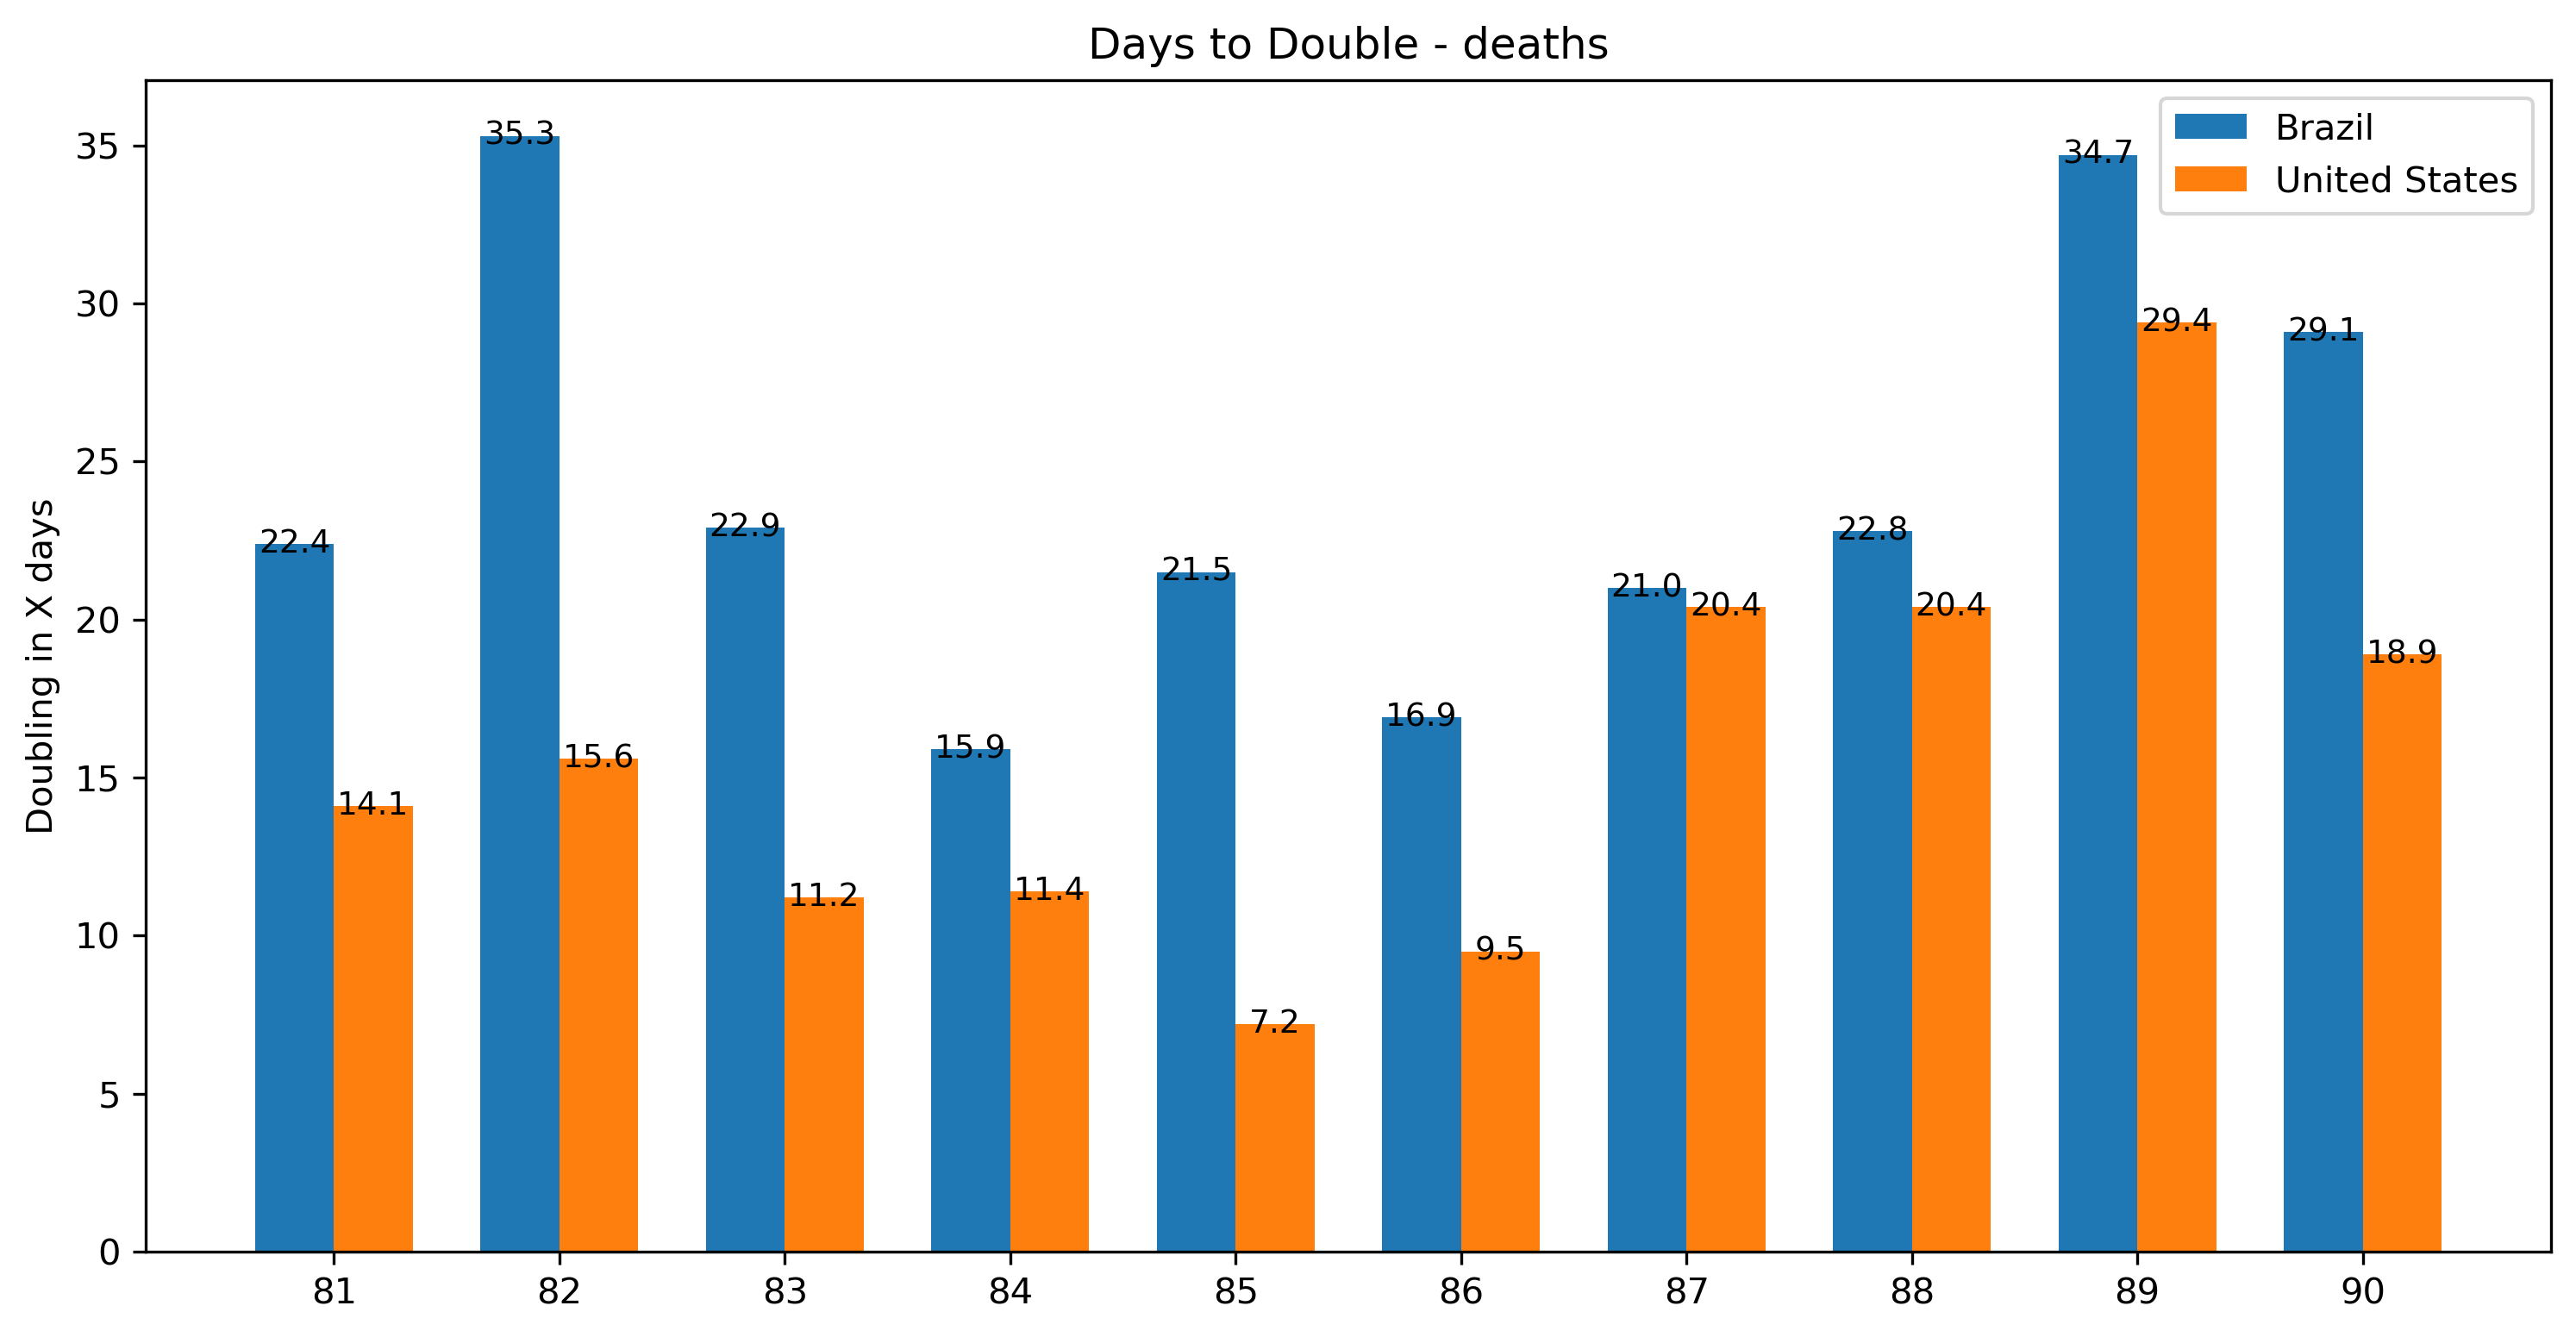

In [19]:
generate_chart_days_to_double(countries, "deaths")

In [20]:
# Generate table of comparison

country_comparison = []
for country in countries:
    country_cases = covid_cases_aggr[covid_cases_aggr["country"] == country]
    country_cases = country_cases[country_cases["confirmed"] > 0]
    country_dates = pd.date_range(start=country_cases.last_update.min(), end=covid_cases_aggr.last_update.max())
    country_cases = country_cases.set_index('last_update').reindex(country_dates).fillna(method='pad').rename_axis('last_update').reset_index()
   
    #country_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
    country_cases["cases_per_million"] = country_cases["confirmed"] / (country_cases["population"] / 1000000)
    country_cases["fatalities_per_million"] = country_cases["deaths"] / (country_cases["population"] / 1000000)
    country_cases["fatalities_per_cases"] = country_cases["deaths"] / country_cases["confirmed"]
    country_cases = country_cases[["last_update", "confirmed", "deaths", "cases_per_million", "fatalities_per_million", "fatalities_per_cases"]]
    country_cases = country_cases.add_prefix(country.replace(" ", " ").lower() + "_")
    country_cases = country_cases.reset_index()
    country_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
    if country == countries[0]:
        country_comparison = country_cases
    else:
        country_comparison = pd.merge(country_comparison, country_cases, left_on='days_since_first_case', right_on='days_since_first_case', how="outer")

ext_folder = os.path.join(os.getcwd(), 'extractions') 
file_name = os.path.join(ext_folder, "contries_comparison.csv")
country_comparison.to_csv(file_name)


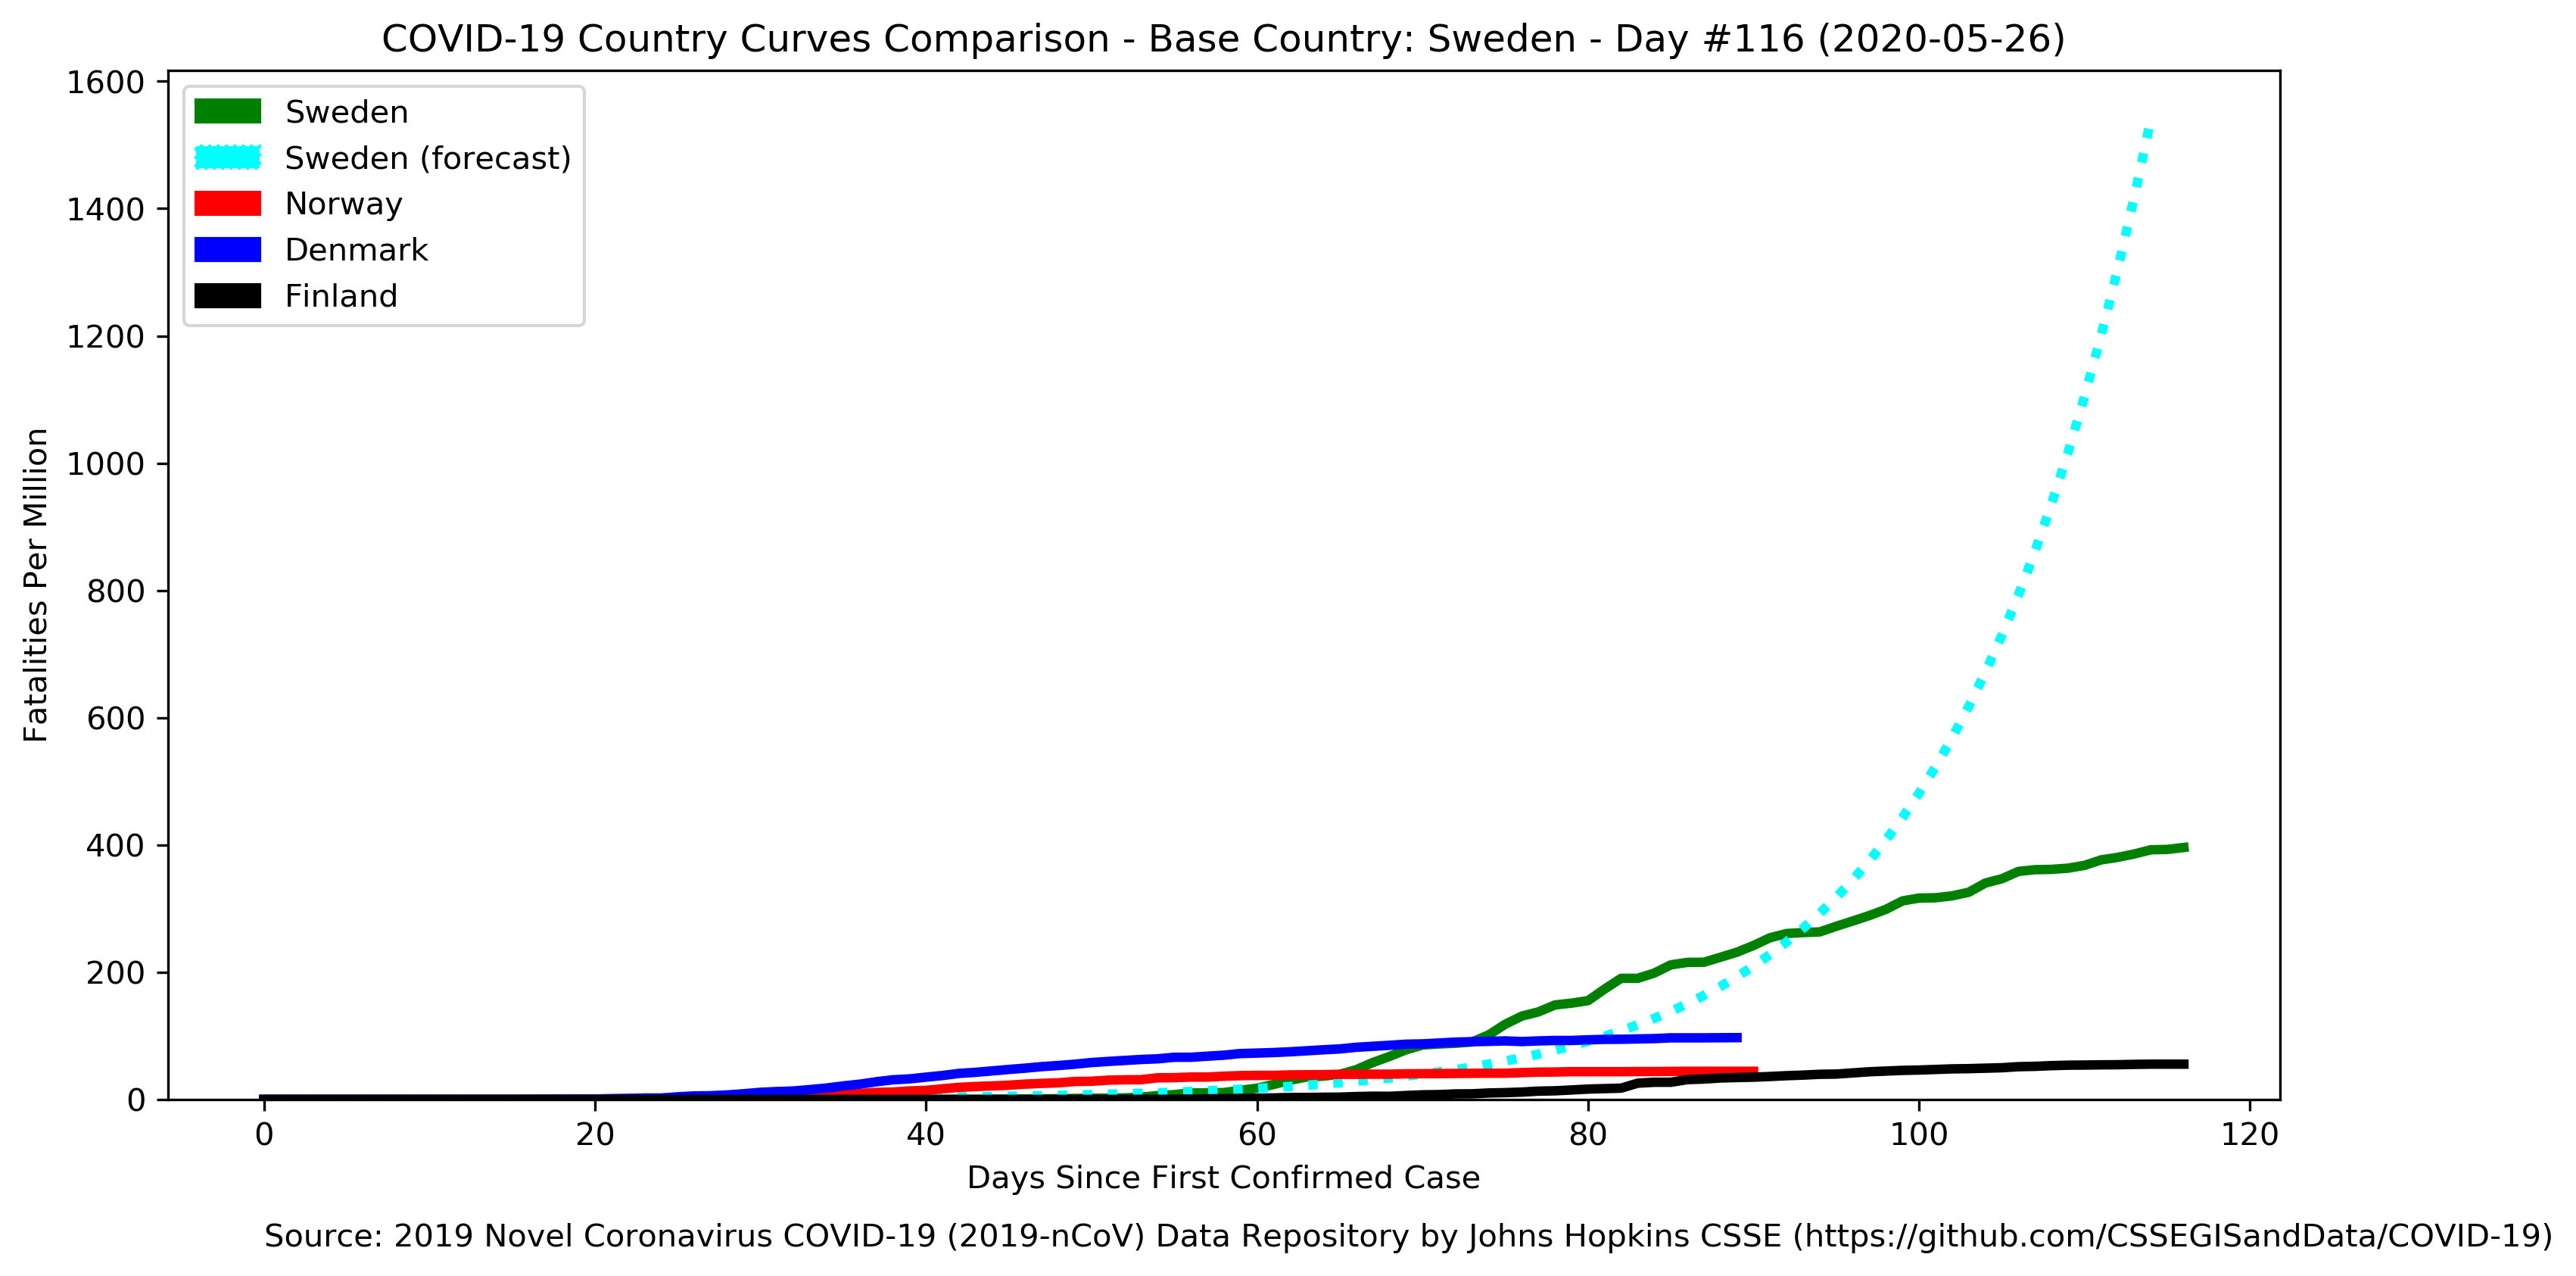

In [21]:
## Just checking how Nordic countries are going
metric = "fatalities_per_million"
countries = ["Sweden", "Norway", "Denmark", "Finland"]
generate_chart(countries=countries, metric=metric, days_to_forecast=0, ending_day=1000)